<a href="https://colab.research.google.com/github/seyonechithrananda/bert-loves-chemistry/blob/master/21_HuggingFace_ChemBERTa_SMILES_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Tensorflow 1.x to allow for RDKit to work (ignore this)
%tensorflow_version 1.x

TensorFlow 1.x selected.


# Tutorial Part 21: Finetuning HuggingFace's RoBERTa for masked language modelling of SMILES

![alt text](https://huggingface.co/front/assets/huggingface_mask.svg)

By Seyone Chithrananda

Deep learning for chemistry and materials science remains a novel field with lots of potiential. However, the popularity of transfer learning based methods in areas such as NLP and computer vision have not yet been effectively developed in computational chemistry + machine learning. Using HuggingFace's suite of models and the ByteLevel tokenizer, we are able to train a large-transformer model, RoBERTa, on a large corpus of 100k SMILES strings from a commonly known benchmark chemistry dataset, ZINC.

Training RoBERTa over 5 epochs, the model achieves a pretty good loss of 0.398, and may likely continue to decrease if trained for a larger number of epochs. The model can predict tokens within a SMILES sequence/molecule, allowing for variants of a molecule within discoverable chemical space to be predicted.

By applying the representations of functional groups and atoms learned by the model, we can try to tackle problems of toxicity, solubility, drug-likeness, and synthesis accessibility on smaller datasets using the learned representations as features for graph convolution and attention models on the graph structure of molecules, as well as fine-tuning of BERT. Finally, we propose the use of attention visualization as a helpful tool for chemistry practitioners and students to quickly identify important substructures in various chemical properties.

Additionally, visualization of the attention mechanism have been seen through previous research as incredibly valuable towards chemical reaction classification. The applications of open-sourcing large-scale transformer models such as RoBERTa with HuggingFace may allow for the acceleration of these individual research directions.

A link to a repository which includes the training, uploading and evaluation notebook (with sample predictions on compounds such as Remdesivir) can be found [here](https://github.com/seyonechithrananda/bert-loves-chemistry). All of the notebooks can be copied into a new Colab runtime for easy execution.

For the sake of this tutorial, we'll be fine-tuning RoBERTa on a small-scale molecule dataset, to show the potiential and effectiveness of HuggingFace's NLP-based transfer learning applied to computational chemistry.

Install HuggingFace's `transformers` tool, as well as RDKit to visualize molecule designs.

In [2]:
!pip uninstall -y tensorflow
!pip install transformers

In [7]:
!wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
!chmod +x Anaconda3-2019.10-Linux-x86_64.sh
!bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local
!conda install -y -c rdkit -c conda-forge -c omnia 
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')


--2020-04-10 04:00:58--  https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 530308481 (506M) [application/x-sh]
Saving to: ‘Anaconda3-2019.10-Linux-x86_64.sh’

Anaconda3-2019.10-L 100%[===================>] 505.74M   103MB/s    in 4.8s    

2020-04-10 04:01:03 (106 MB/s) - ‘Anaconda3-2019.10-Linux-x86_64.sh’ saved [530308481/530308481]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / failed with initial frozen solv

Since I've uploaded my pretrained RoBERTa model to HuggingFace's model hub, we can utilize HuggingFace's `AutoModelWithLMHead` to load the pre-trained model, and `AutoTokenizer` to load the pre-trained tokenizer. `Pipeline` will help us load the model, tokenizer on masked language prediction. 


In [0]:
from transformers import AutoModelWithLMHead, AutoTokenizer, pipeline

model = AutoModelWithLMHead.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

fill_mask = pipeline('fill-mask', model=model, tokenizer=tokenizer)

Now, to ensure our model demonstrates an understanding of chemical syntax and molecular structure, we'll be testing it on predicting a masked token/character within the SMILES molecule for Remdesivir.

In [5]:
remdesivir_mask = "CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=<mask>1"
remdesivir = "CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=C1"

"CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=O1"


print(fill_mask(remdesivir_mask))

[{'sequence': '<s> CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=C1</s>', 'score': 0.5986586809158325, 'token': 39}, {'sequence': '<s> CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=O1</s>', 'score': 0.09766950458288193, 'token': 51}, {'sequence': '<s> CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=N1</s>', 'score': 0.07694468647241592, 'token': 50}, {'sequence': '<s> CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=21</s>', 'score': 0.0241263248026371, 'token': 22}, {'sequence': '<s> CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=H1</s>', 'score': 0.0188530795276165, 'token': 44}]


Here, we get some interesting results. The final branch, `C1=CC=CC=C1`, is a  benzene ring. Since its a pretty common molecule, the model is easily able to predict the final double carbon bond with a score of 0.60. Let's get a list of the top 5 predictions (including the target, Remdesivir), and visualize them (with a highlighted focus on the beginning of the final benzene-like pattern). Lets import some various RDKit packages to do so.


In [0]:
import torch
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import rdFMCS
from matplotlib import colors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import MolToImage
from PIL import Image


def get_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    Chem.Kekulize(mol)
    return mol


def find_matches_one(mol,submol):
    #find all matching atoms for each submol in submol_list in mol.
    match_dict = {}
    mols = [mol,submol] #pairwise search
    res=rdFMCS.FindMCS(mols) #,ringMatchesRingOnly=True)
    mcsp = Chem.MolFromSmarts(res.smartsString)
    matches = mol.GetSubstructMatches(mcsp)
    return matches

#Draw the molecule
def get_image(mol,atomset):    
    hcolor = colors.to_rgb('green')
    if atomset is not None:
        #highlight the atoms set while drawing the whole molecule.
        img = MolToImage(mol, size=(600, 600),fitImage=True, highlightAtoms=atomset,highlightColor=hcolor)
    else:
        img = MolToImage(mol, size=(400, 400),fitImage=True)
    return img

    

In [84]:
sequence = f"CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC={tokenizer.mask_token}1"
substructure = "CC=CC"
image_list = []

input = tokenizer.encode(sequence, return_tensors="pt")
mask_token_index = torch.where(input == tokenizer.mask_token_id)[1]

token_logits = model(input)[0]
mask_token_logits = token_logits[0, mask_token_index, :]

top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

for token in top_5_tokens:
  smi = (sequence.replace(tokenizer.mask_token, tokenizer.decode([token])))
  print (smi)
  smi_mol = get_mol(smi)
  substructure_mol = get_mol(substructure)
  if smi_mol is None: # if the model's token prediction isn't chemically feasible
    continue
  Draw.MolToFile(smi_mol, smi+".png")
  matches = find_matches_one(smi_mol, substructure_mol)
  atomset = list(matches[0])
  img = get_image(smi_mol, atomset)
  img.format="PNG" 
  image_list.append(img)


CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=C1
[18, 25, 26, 27]
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=600x600 at 0x7F22EEA23160>
CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=O1
CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=N1
[18, 25, 26, 27]
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=600x600 at 0x7F22EEA23198>
CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=21
CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=H1


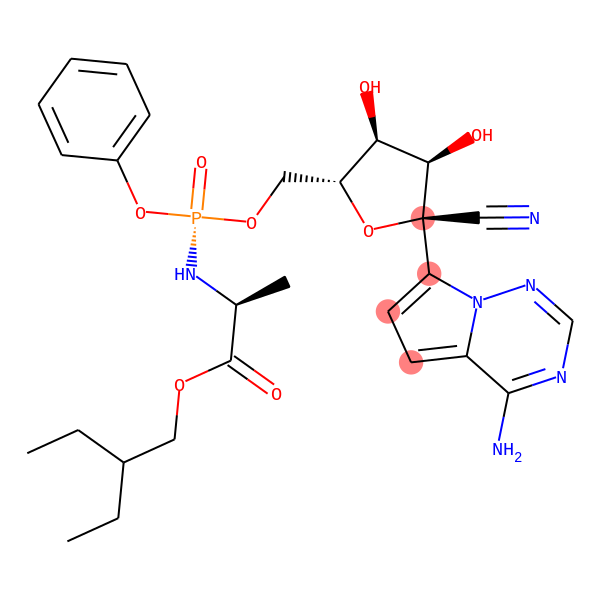

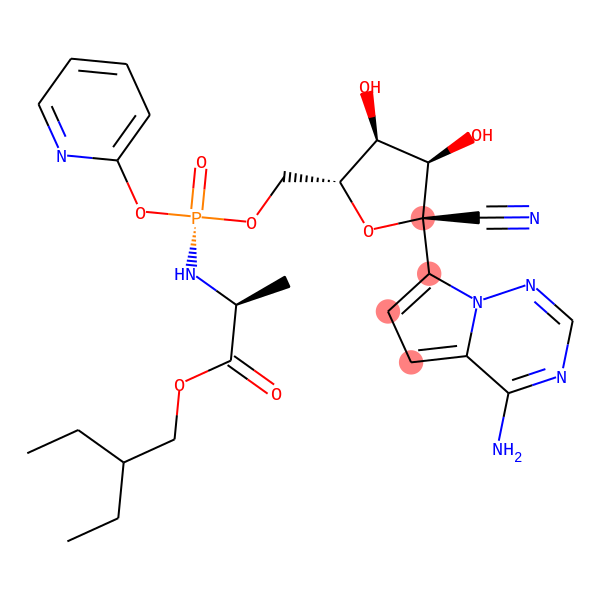

In [87]:
from IPython.display import Image 

for img in image_list:
  display(img)

As we can see above, 2 of 4 of the model's MLM predictions are chemically valid. The one the model would've chosen (with a score of 0.6), is the first image, in which the top left molecular structure resembles the benzene found in the therapy Remdesivir. Overall, the model seems to understand syntax with a pretty decent degree of certainity. 

However, further training on a more specific dataset (say leads for a specific target) may generate a stronger MLM model. Let's now fine-tune our model on a dataset of our choice. [fine-tuning still needs to be fleshed out]

# Fine-tuning ChemBERTa on a Small Mollecular Dataset